In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
from matplotlib.colors import ListedColormap
import copy

### Remove extraneous columns from the promoter / peak intersect file

In [4]:
# promoterintersectfilename = '/nfs/lab/jnewsome/pbmc/peaks_intersect_promoters.HIGHSPECFILTER.bed'
# reducecolfilename = '/nfs/lab/jnewsome/pbmc/peaks_intersect_promoters.HIGHSPECFILTER.lesscol.bed'

# promfile = open(promoterintersectfilename)
# reducecolfile = open(reducecolfilename, 'w')
# for line in promfile:
#     line = line.strip()
#     if len(line) > 0:
#         s = line.split()
#         chrom = s[0]
#         start = s[1]
#         end = s[2]
#         gene = s[7]
#         outline = chrom + '\t' + start + '\t' + end + '\t' + gene + '\n'
#         reducecolfile.write(outline)
# promfile.close()
# reducecolfile.close()
# #   0       1        2           3         4         5       6       7
# # chr1    1265807 1266809 mem_b,plasma    chr1    1266194 1267194 TAS1R3
# # chr1    1293848 1294360 naive_cd4_t,cMono,naive_cd8_t,act_cd4_t,cDC,cyto_nk,ncMono,iMono     chr1     1293415 1294415 MXRA8


### Inputs

In [5]:
indir = '/nfs/lab/jnewsome/pbmc/highSpecIntersect/'
broadPops_wPlasma = ['b', 'mono', 'cd4_t_AND_cd8_t', 'nk', 'cd4_t', 
             'pDC', 'cd8_t', 'mkc', 'plasma',  ]
broadPops = ['b', 'mono', 'cd4_t_AND_cd8_t', 'nk', 'cd4_t', 
             'pDC', 'cd8_t', 'mkc',  ]

finePops = ['act_cd4_t', 'mem_b',  'adaptive_NK', 'mem_cd8_t', 
            'cDC', 'mkc', 'naive_b', 'naive_cd4_t',
             'cyto_cd8_t', 'naive_cd8_t', 'ncMono',  'cMono',  
            'cyto_nk', 'pDC', 'plasma',  'iMono',  'tReg']


geneList = ['AC233755.1', 'COL19A1', 'C1QC', 'MERTK', 'C2', 'COX6A2', 
            'ZMAT4', 'APOC2', 'LRRC26', 'TPM2', 'FANK1', 'CTLA4', 
            'S1PR3', 'RXFP2', 'KRT7', 'L1TD1', 'CTTNBP2', 'TAS1R3', 
            'APOD', 'KCNG1', 'APBB2', 'ADAM23', 'CFAP97D2', 'MXRA8', 
            'SEMA3G', 'ACTG2']

inprefix = '/nfs/lab/jnewsome/pbmc/highSpecIntersect/pbmc1-15.'
insuffix = '.highSpecGeneIntersect.1kbprom.tagAlign'
barcodeFileName = '/nfs/lab/jnewsome/pbmc/pbmc1-15.barcodeClusterNames.FINAL.AllCellTypes.txt'




cellTypesDict_colors_broad = {
    'cd4_t' :  '255,0,255', # magenta
    'mono' :  '127,201,127', # green 
    'cd8_t' : '0,231,244', #blue 
    'nk' :  '139,90,43', # tan4
    'b' :  '238,154,0', # orange
    'mkc' :  '170,110,40',  # brown
    'plasma' :  '75,0,130', #indigo
    'pDC' :  '81,54,26',  # dark brown
    't' : '139,0,139',  # dark brown
    'cd4_t_AND_cd8_t' : '221,160,221',
}


cellTypesDict_colors = {
    'act_cd4_t' : '247,129,191',
    'naive_cd4_t' :  '231,41,138', 
    'tReg' :  '255,0,0', 
    'ncMono' :  '166,216,84',
    'iMono' : '0,139,0', 
    'cMono' :  '180,238,180',  
    'cDC' :  '0,139,139', 
    'cyto_cd8_t' : '31,120,180',
    'naive_cd8_t' : '179,205,227',
    'mem_cd8_t' :  '0,178,238',
    'cyto_nk' :  '166,86,40',
    'adaptive_NK' :  '241,226,204', 
    'naive_b' :  '253,192,134', 
    'mem_b' :  '255,127,0', 
    'mkc' :  '188,128,189', 
    'plasma' :  '255,215,0', 
    'pDC' :  '179,179,179', 
}


broadFineColors = {
    'cd4_t' :  '255,0,255', # magenta
    'mono' :  '127,201,127', # green 
    'cd8_t' : '0,231,244', #blue 
    'nk' :  '139,90,43', # tan4
    'b' :  '238,154,0', # orange
    't'  : '221,160,221',
    'act_cd4_t' : '247,129,191',
    'naive_cd4_t' :  '231,41,138', 
    'tReg' :  '255,0,0', 
    'ncMono' :  '166,216,84',
    'iMono' : '0,139,0', 
    'cMono' :  '180,238,180',  
    'cDC' :  '0,139,139', 
    'cyto_cd8_t' : '31,120,180',
    'naive_cd8_t' : '179,205,227',
    'mem_cd8_t' :  '0,178,238',
    'cyto_nk' :  '166,86,40',
    'adaptive_NK' :  '241,226,204', 
    'naive_b' :  '253,192,134', 
    'mem_b' :  '255,127,0', 
    'mkc' :  '188,128,189', 
    'plasma' :  '255,215,0', 
    'pDC' :  '179,179,179',     
    
}



fine_color_scaled = {}
for c in cellTypesDict_colors.keys():
    col = cellTypesDict_colors[c]
    s = col.split(',')
    r = int(s[0]) / 255
    g = int(s[1]) / 255
    b = int(s[2]) / 255
    fine_color_scaled[c] = (r, g, b)
    
broad_color_scaled = {}
for c in cellTypesDict_colors_broad.keys():
    col = cellTypesDict_colors_broad[c]
    s = col.split(',')
    r = int(s[0]) / 255
    g = int(s[1]) / 255
    b = int(s[2]) / 255
    broad_color_scaled[c] = (r, g, b)

broadfine_color_scaled = {}
for c in broadFineColors.keys():
    col = broadFineColors[c]
    s = col.split(',')
    r = int(s[0]) / 255
    g = int(s[1]) / 255
    b = int(s[2]) / 255
    broadfine_color_scaled[c] = (r, g, b)


geneTitleDict = {
    'COL19A1': 'COL19A1: B Cells', # COL19A1
    'C1QC':  'C1QC: Monocytes', # C1QC
   'MERTK':  'MERTK: Monocytes', # MERTK
    'C2':  'C2: Monocytes', # C2
   'COX6A2':  'COX6A2: NK Cells', # COX6A2
    'ZMAT4':  'ZMAT4: NK Cells', # ZMAT4
    'APOC2':  'APOC2: NK Cells', # APOC2
    'LRRC26':  'LRRC26: pDCs', # LRRC26
   'TPM2':  'TPM2: pDCs', # TPM2
   'FANK1':  'FANK1: T-Cells', # FANK1
   'CTLA4':  'CTLA4: T-Cells', # CTLA4
 'S1PR3':  'S1PR3: Classical Monocytes', # S1PR3
   'RXFP2':  'RXFP2: Classical Monocytes', # RXFP2
   'KRT7':  'KRT7: Intermediate Monocytes', # KRT7
   'L1TD1':  'L1TD1: Non-Classical Monocytes', # L1TD1
   'CTTNBP2': 'CTTNBP2: Non-Classical Monocytes', # CTTNBP2
  'TAS1R3':  'TAS1R3: Memory B Cells', # TAS1R3
  'APOD':  'APOD: Memory B Cells', # APOD
   'KCNG1':  'KCNG1: Naive B Cells', # KCNG1
    'APBB2':  'APBB2: Naive B Cells', # APBB2
 'ADAM23': 'ADAM23: Memory CD4+ T-cells', # ADAM23
   'CFAP97D2':  'CFAP97D2: Naive CD8+ T-cells',
   'MXRA8':  'MXRA8: Naive CD8+ T-cells', # MXRA8
  'SEMA3G':  'SEMA3G: Regulatory CD4+ T-cells', # SEMA3G
  'ACTG2': 'ACTG2: Regulatory CD4+ T-cells', # ACTG2
}



### Read prom intersected tagalign file to gene --> pop ---> [barcode] dict

In [6]:
dict1 = {}
for gene in geneList:
    dict1[gene] = {}
    dict1[gene]['broadPops'] = {}
    dict1[gene]['finePops'] = {}
    for pop in broadPops:
        dict1[gene]['broadPops'][pop] = defaultdict(int)
    for pop in finePops:
        dict1[gene]['finePops'][pop] = defaultdict(int)

for pop in broadPops_wPlasma:
    print(pop)
    tagfilename = inprefix + pop + insuffix
    if pop == 'plasma':
        pop = 'b'
    tagfile = open(tagfilename)
    for line in tagfile:
        line = line.strip()
        # chr1	1266484	1266684	pbmc8_CTCTACGCAATACTGC	60	-	chr1	1266683	1266704	TAS1R3
        #  0     1        2            3                4   5    6        7        8      9
        s = line.split()
        bar = s[3]
        gene = s[9]
        dict1[gene]['broadPops'][pop][bar] += 1  
print('done!')        

for pop in finePops:
    print(pop)
    tagfilename = inprefix + pop + insuffix
    tagfile = open(tagfilename)
    for line in tagfile:
        line = line.strip()
        s = line.split()
        bar = s[3]
        gene = s[9]
        dict1[gene]['finePops'][pop][bar] += 1
            
print('done!')        

b
mono
cd4_t_AND_cd8_t
nk
cd4_t
pDC
cd8_t
mkc
plasma
done!
act_cd4_t
mem_b
adaptive_NK
mem_cd8_t
cDC
mkc
naive_b
naive_cd4_t
cyto_cd8_t
naive_cd8_t
ncMono
cMono
cyto_nk
pDC
plasma
iMono
tReg
done!


### Read total barcodes from barcode file

In [7]:
barDict = {}
barDict['finePops'] = {}
barDict['broadPops'] = {}
for pop in broadPops:
    barDict['broadPops'][pop] = list()
    
for pop in finePops:
    barDict['finePops'][pop] = list()
    

barfile = open(barcodeFileName)
for line in barfile:
    line = line.strip()
    if not line.startswith('sample'):
        s = line.split()
        bar = s[0]
        broadPop = s[5]
        finePop = s[4]
        
        if broadPop == 'plasma':
            broadPop = 'b'
        
        
        barDict['finePops'][finePop].append(bar)
        barDict['broadPops'][broadPop].append(bar)

# sample	leiden	subcluster	fine_populations	broad_populations	fine_populations_long	broad_populations_long	UMAP1	UMAP2	unique_usable_reads	total_sequenced_reads	duplicated_reads	unique_mito_reads	reads_in_peaks	reads_in_promoters	tss_used	frac_reads_in_peaks	frac_reads_in_promoters	frac_promoters_used	frac_mito_reads	frac_duplicated_reads	log10_unique_usable_reads	n_counts	log10_usable_counts	norm
#   0         1        2          4       
# pbmc1_AAACGAAAGAAAGGGT	pbmc1	5	5,17	cyto_nk	nk	Cytotoxic NK Cells	NK Cells	16.3818	4.42573	18920	27626	8419	146	13178	7862	3114	0.6965116279069767	0.4155391120507399	0.160963506668045	0.0076576104059582	0.3047491493520596	4.27694408571298219042.0	3.450249195098877	0
#    0                       1      2    3       4 
barfile.close()

In [8]:
######################## double check populations in barcodes file
# uniquePopDict_broad = {}
# uniquePopDict_fine = {}
# barfile = open(barcodeFileName)
# for line in barfile:
    
#     line = line.strip()
#     if not line.startswith('sample'):
#         s = line.split()
#         broadPop = s[5]
#         finePop = s[4]
# #         print(broadPop, finePop)
#         uniquePopDict_broad[broadPop] = broadPop
#         uniquePopDict_fine[finePop] = finePop
# barfile.close()

In [9]:
# uniquePopDict_broad['plasma']

# uniquePopDict_fine.keys()

# for pop in barDict['finePops'].keys():
#     print(pop, len(barDict['finePops'][pop]))
# len(barDict['broadPops'])

In [10]:
geneList = ['COL19A1', 'C1QC', 'MERTK', 'C2', 'COX6A2', 
            'ZMAT4', 'APOC2', 'LRRC26', 'TPM2', 'FANK1', 'CTLA4', 
            'S1PR3', 'RXFP2', 'KRT7', 'L1TD1', 'CTTNBP2', 'TAS1R3', 
            'APOD', 'KCNG1', 'APBB2', 'ADAM23', 'MXRA8', 
            'SEMA3G', 'ACTG2']

In [11]:
colList = ['Cell_Type']
colList = colList + geneList
broad = pd.DataFrame(columns = geneList)
fine = pd.DataFrame(columns = geneList)

for pop in broadPops:
    addColDict = {}
    addColDict['Cell_Type'] = pop
    if pop == 'cd4_t_AND_cd8_t':
        totalCount = len(barDict['broadPops']['cd4_t']) + len(barDict['broadPops']['cd8_t'])
    else:
        totalCount = len(barDict['broadPops'][pop])
    for gene in geneList:
        count = len(dict1[gene]['broadPops'][pop].keys())
        prop = count / totalCount
        addColDict[gene] = prop
    broad = broad.append(addColDict, 
                    ignore_index = True)

for pop in finePops:
    addColDict = {}
    addColDict['Cell_Type'] = pop    
    if pop == 'cd4_t_AND_cd8_t':
        totalCount = len(barDict['finePops']['cd4_t']) + len(barDict['finePops']['cd8_t'])
#         print('cd4_t_AND_cd8_t')
    else:
        totalCount = len(barDict['finePops'][pop])
        
    for gene in geneList:
        count = len(dict1[gene]['finePops'][pop].keys())
#         print('pop = ', pop, 'gene = ', gene, 'totalCount = ', totalCount, 'count = ', count)
        prop = count / totalCount
        addColDict[gene] = prop
    fine = fine.append(addColDict, 
                    ignore_index = True)
    
broad.index = broad['Cell_Type']
fine.index = fine['Cell_Type']
# broad = broad.drop(['Cell_Type'], axis = 1)
# fine = fine.drop(['Cell_Type'], axis = 1)
broad = broad.drop(['Cell_Type'], axis = 1)

In [12]:
newRowOrderFine = [ 'mem_b', 'naive_b', 'plasma',  
                    'adaptive_NK', 'cyto_nk', 
                    'act_cd4_t', 'naive_cd4_t', 'tReg', 
                    'mem_cd8_t',  'cyto_cd8_t', 'naive_cd8_t', 
                    'ncMono',  'cMono',   'iMono', 'cDC',
                    'mkc', 'pDC',  ]
fine = fine.reindex(newRowOrderFine)

newRowOrderBroad = ['b', 'nk', 'mono',
                    'cd4_t_AND_cd8_t', 'cd4_t', 'cd8_t',
                     'mkc', 'pDC',  ]
broad = broad.reindex(newRowOrderBroad)

In [13]:
broadLabel = ['b', 'nk', 'mono',
                    't', 'cd4_t', 'cd8_t',
                     'mkc', 'pDC',  ]

In [14]:
broad

,COL19A1,C1QC,MERTK,C2,COX6A2,ZMAT4,APOC2,LRRC26,TPM2,FANK1,...,L1TD1,CTTNBP2,TAS1R3,APOD,KCNG1,APBB2,ADAM23,MXRA8,SEMA3G,ACTG2
Cell_Type,,,,,,,,,,,,,,,,,,,,,
b,0.140969,0.000534,0.053931,0.135095,0.002536,0.000534,0.002136,0.005206,0.032038,0.075958,...,0.001335,0.002269,0.006675,0.000934,0.045121,0.088907,0.047524,0.007209,0.066079,0.000534
nk,0.021337,0.000739,0.071512,0.182846,0.028626,0.025457,0.009295,0.004753,0.057040,0.123059,...,0.000951,0.001056,0.002429,0.001162,0.021971,0.014049,0.004014,0.009824,0.066441,0.001690
mono,0.010847,0.003067,0.083452,0.120448,0.007038,0.000743,0.010363,0.003745,0.063630,0.119576,...,0.014495,0.024051,0.003196,0.001776,0.017917,0.107180,0.009620,0.014301,0.080127,0.001453
cd4_t_AND_cd8_t,0.047780,0.000837,0.055961,0.180725,0.007731,0.000902,0.002534,0.004746,0.039254,0.055961,...,0.001353,0.002470,0.002813,0.001525,0.009105,0.031309,0.027186,0.010694,0.075739,0.001074
cd4_t,0.049640,0.000743,0.059372,0.182273,0.004697,0.001048,0.002501,0.005373,0.038455,0.054270,...,0.001453,0.002501,0.002636,0.001419,0.009495,0.035684,0.037576,0.010509,0.079073,0.001149
cd8_t,0.044536,0.001001,0.050015,0.178027,0.013019,0.000648,0.002592,0.003652,0.040648,0.058910,...,0.001178,0.002415,0.003122,0.001708,0.008424,0.023682,0.009072,0.011016,0.069926,0.000943
mkc,0.006250,0.000000,0.013393,0.112500,0.004464,0.000893,0.007143,0.003571,0.033036,0.067857,...,0.000893,0.002679,0.000000,0.000000,0.000893,0.018750,0.003571,0.003571,0.009821,0.000893
pDC,0.021053,0.005263,0.076316,0.139474,0.007895,0.000000,0.002632,0.047368,0.107895,0.100000,...,0.000000,0.015789,0.002632,0.002632,0.018421,0.152632,0.010526,0.021053,0.071053,0.000000


In [15]:
fine

,COL19A1,C1QC,MERTK,C2,COX6A2,ZMAT4,APOC2,LRRC26,TPM2,FANK1,...,CTTNBP2,TAS1R3,APOD,KCNG1,APBB2,ADAM23,MXRA8,SEMA3G,ACTG2,Cell_Type
Cell_Type,,,,,,,,,,,,,,,,,,,,,
mem_b,0.144578,0.000000,0.054217,0.180723,0.002317,0.000927,0.002317,0.006487,0.028730,0.080630,...,0.006024,0.015755,0.001390,0.015292,0.063948,0.019462,0.009268,0.085728,0.000463,mem_b
naive_b,0.138986,0.000774,0.052071,0.113821,0.002710,0.000387,0.001936,0.004259,0.032907,0.071816,...,0.000774,0.002323,0.000774,0.057298,0.098916,0.059621,0.006194,0.055362,0.000581,naive_b
plasma,0.155689,0.000000,0.107784,0.203593,0.000000,0.000000,0.005988,0.017964,0.047904,0.143713,...,0.000000,0.023952,0.000000,0.053892,0.101796,0.035928,0.011976,0.143713,0.000000,plasma
adaptive_NK,0.027180,0.001133,0.130238,0.159683,0.040770,0.064553,0.028313,0.009060,0.058890,0.134768,...,0.005663,0.001133,0.000000,0.010193,0.028313,0.005663,0.012458,0.052095,0.002265,adaptive_NK
cyto_nk,0.020736,0.000699,0.065471,0.185228,0.027377,0.021435,0.007339,0.004310,0.056850,0.121855,...,0.000582,0.002563,0.001281,0.023183,0.012582,0.003844,0.009553,0.067917,0.001631,cyto_nk
act_cd4_t,0.055183,0.000774,0.066155,0.202982,0.005228,0.000645,0.002904,0.006390,0.044792,0.057248,...,0.002194,0.002840,0.001807,0.012908,0.029366,0.051633,0.011166,0.088486,0.001162,act_cd4_t
naive_cd4_t,0.047186,0.000667,0.053772,0.154815,0.004335,0.001167,0.001834,0.004585,0.033764,0.050771,...,0.002584,0.002501,0.000917,0.004835,0.047186,0.023927,0.009671,0.059275,0.000834,naive_cd4_t
tReg,0.022814,0.000951,0.041350,0.186312,0.002852,0.003327,0.003327,0.002376,0.018536,0.052281,...,0.004278,0.001901,0.001426,0.010932,0.016635,0.011882,0.010456,0.122624,0.002852,tReg
mem_cd8_t,0.034082,0.000802,0.060545,0.174820,0.019246,0.000000,0.003609,0.004010,0.056937,0.087009,...,0.002807,0.005213,0.001604,0.007618,0.004812,0.006014,0.006014,0.070569,0.000802,mem_cd8_t


In [16]:
# # plot1 = fine.plot.bar(x="Cell_Type", y="COL19A1", c = cellTypesDict_colors,
# #         width = 0.4)

# plt.bar(x="Cell_Type", y="COL19A1", c = cellTypesDict_colors,
#         width = 0.4, height = 0.4)
# # df.plot(x="Cell_Type", y=["COL19A1"])
# plt.show()

In [17]:

def setFinePopSubFig (geneName):
    plot1 = sns.barplot(x = 'Cell_Type',
            y = geneName,
            data = fine, palette=fine_color_scaled, )


    sns.set(font_scale = 1)
    # plot1.set_yticklabels( size = 10)
    plot1.set_xticklabels(fine.index, size = 10,rotation = 30, ha='right')
    plot1.set_xlabel("Cell Sub-type", fontsize = 20)
    plot1.set_ylabel("Proportion of Nuclei", fontsize = 20)
    plot1.set_title(geneName, fontsize = 20)
    return plot1


def setBroadPopSubFig (geneName):
    plot1 = sns.barplot(x = broad.index,
            y = geneName,
            data = broad, palette=broad_color_scaled, )
    # plot1.set_yticklabels(plot1.get_yticklabels(), size = 10)
    plot1.set_xticklabels(broadLabel, size = 12,rotation = 30, ha='right')
    plot1.set_xlabel("Cell Type", fontsize = 15)
    plot1.set_ylabel("Proportion of Nuclei", fontsize = 15)
    plot1.set_title(geneName, fontsize = 20)
    return plot1


def setBroadFinePopSubFig (geneName, plotTitle):
    plot1 = sns.barplot(x = broadfine.index,
            y = geneName,
            data = broadfine, palette=broadfine_color_scaled, )
    # plot1.set_yticklabels(plot1.get_yticklabels(), size = 10)
    plot1.set_xticklabels(plot1.get_xticklabels(), size = 12,rotation = 30, ha='right')
    plot1.set_xlabel("Cell Type", fontsize = 15)
    plot1.set_ylabel("Proportion of Nuclei", fontsize = 15)
    plot1.set_title(plotTitle, fontsize = 20)
    return plot1





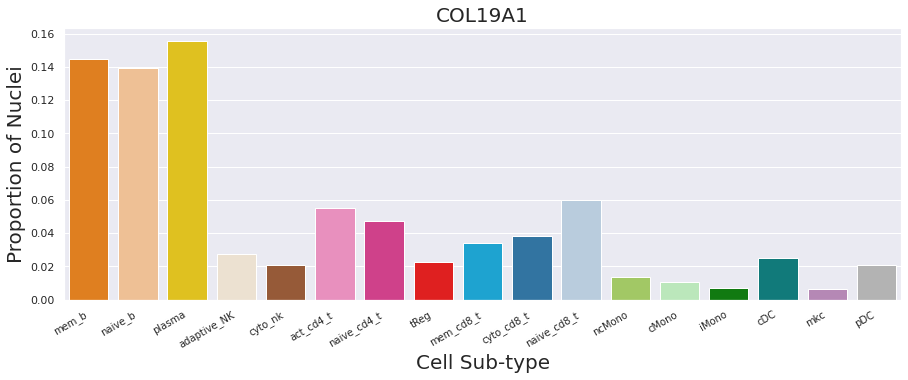

In [18]:
sns.set(font_scale = 1)
plotA = setFinePopSubFig ("COL19A1")
plt.gcf().set_size_inches(15, 5)
plt.show()

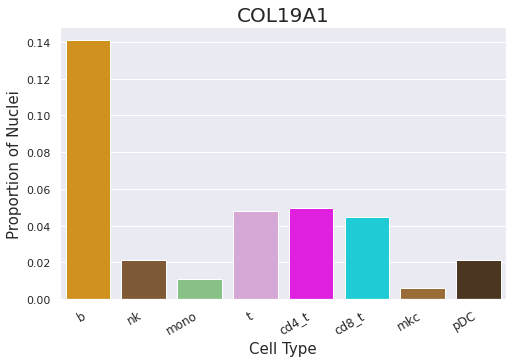

In [19]:
sns.set(font_scale = 1)
plotB = setBroadPopSubFig ('COL19A1')
plt.gcf().set_size_inches(8, 5)
plt.show()

In [20]:
broadfine = copy.deepcopy(broad)
broadfine = broadfine.append(fine)
broadfine = broadfine.drop(index='cd4_t')
broadfine = broadfine.drop(index='cd8_t')
indlist = list(broadfine.index.values)
indlist2 = list()
for ind in indlist:
    if ind == 'cd4_t_AND_cd8_t':
        ind = 't'
    indlist2.append(ind)

broadfine.index = indlist2

broadfine

,COL19A1,C1QC,MERTK,C2,COX6A2,ZMAT4,APOC2,LRRC26,TPM2,FANK1,...,CTTNBP2,TAS1R3,APOD,KCNG1,APBB2,ADAM23,MXRA8,SEMA3G,ACTG2,Cell_Type
b,0.140969,0.000534,0.053931,0.135095,0.002536,0.000534,0.002136,0.005206,0.032038,0.075958,...,0.002269,0.006675,0.000934,0.045121,0.088907,0.047524,0.007209,0.066079,0.000534,NaN
nk,0.021337,0.000739,0.071512,0.182846,0.028626,0.025457,0.009295,0.004753,0.057040,0.123059,...,0.001056,0.002429,0.001162,0.021971,0.014049,0.004014,0.009824,0.066441,0.001690,NaN
mono,0.010847,0.003067,0.083452,0.120448,0.007038,0.000743,0.010363,0.003745,0.063630,0.119576,...,0.024051,0.003196,0.001776,0.017917,0.107180,0.009620,0.014301,0.080127,0.001453,NaN
t,0.047780,0.000837,0.055961,0.180725,0.007731,0.000902,0.002534,0.004746,0.039254,0.055961,...,0.002470,0.002813,0.001525,0.009105,0.031309,0.027186,0.010694,0.075739,0.001074,NaN
mkc,0.006250,0.000000,0.013393,0.112500,0.004464,0.000893,0.007143,0.003571,0.033036,0.067857,...,0.002679,0.000000,0.000000,0.000893,0.018750,0.003571,0.003571,0.009821,0.000893,NaN
pDC,0.021053,0.005263,0.076316,0.139474,0.007895,0.000000,0.002632,0.047368,0.107895,0.100000,...,0.015789,0.002632,0.002632,0.018421,0.152632,0.010526,0.021053,0.071053,0.000000,NaN
mem_b,0.144578,0.000000,0.054217,0.180723,0.002317,0.000927,0.002317,0.006487,0.028730,0.080630,...,0.006024,0.015755,0.001390,0.015292,0.063948,0.019462,0.009268,0.085728,0.000463,mem_b
naive_b,0.138986,0.000774,0.052071,0.113821,0.002710,0.000387,0.001936,0.004259,0.032907,0.071816,...,0.000774,0.002323,0.000774,0.057298,0.098916,0.059621,0.006194,0.055362,0.000581,naive_b
plasma,0.155689,0.000000,0.107784,0.203593,0.000000,0.000000,0.005988,0.017964,0.047904,0.143713,...,0.000000,0.023952,0.000000,0.053892,0.101796,0.035928,0.011976,0.143713,0.000000,plasma
adaptive_NK,0.027180,0.001133,0.130238,0.159683,0.040770,0.064553,0.028313,0.009060,0.058890,0.134768,...,0.005663,0.001133,0.000000,0.010193,0.028313,0.005663,0.012458,0.052095,0.002265,adaptive_NK


In [21]:
broadfine.columns

Index(['COL19A1', 'C1QC', 'MERTK', 'C2', 'COX6A2', 'ZMAT4', 'APOC2', 'LRRC26',
       'TPM2', 'FANK1', 'CTLA4', 'S1PR3', 'RXFP2', 'KRT7', 'L1TD1', 'CTTNBP2',
       'TAS1R3', 'APOD', 'KCNG1', 'APBB2', 'ADAM23', 'MXRA8', 'SEMA3G',
       'ACTG2', 'Cell_Type'],
      dtype='object')

In [22]:
broadfine = broadfine.drop('C1QC', axis = 1)
broadfine = broadfine.drop('ACTG2', axis = 1)

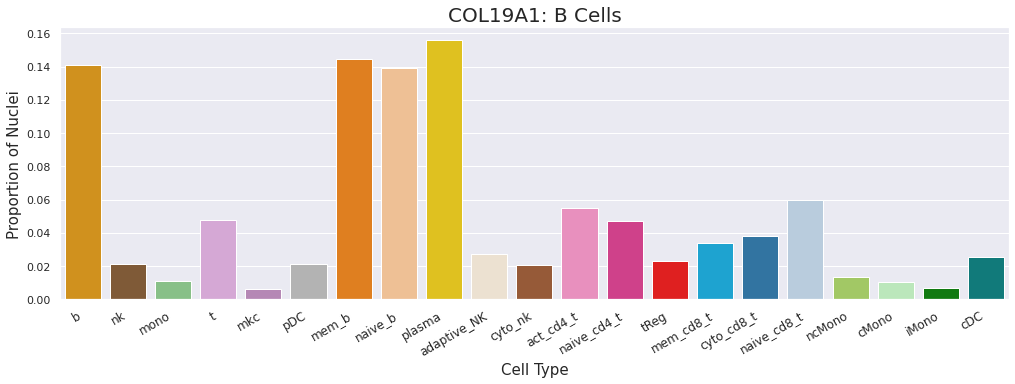

In [23]:
sns.set(font_scale = 1)
plotB = setBroadFinePopSubFig ('COL19A1', 'COL19A1: B Cells')
plt.gcf().set_size_inches(17, 5)
plt.show()

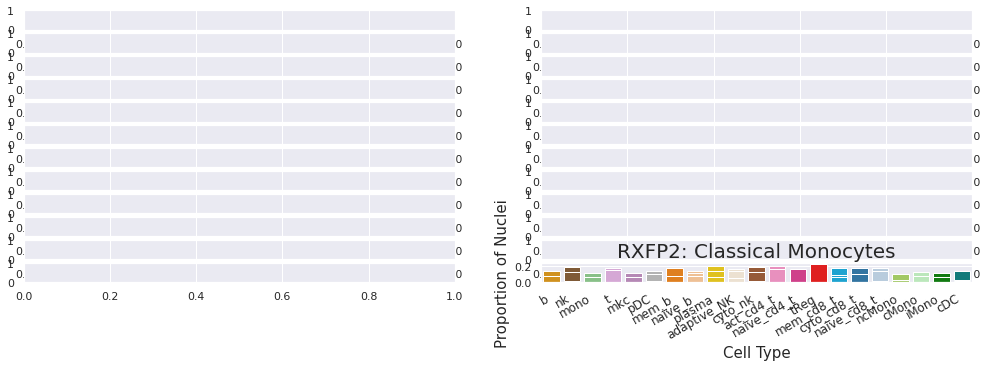

In [24]:
fig, ax = plt.subplots(12, 2)
# sns.set(font_scale = 1)
# sns.set(font_scale = 1)
plt.gcf().set_size_inches(17, 5)

k = 0
collist = list(broadfine.columns)
for i in range(0,12):
    for j in range(0,1):
        gene = collist[k]
        title = geneTitleDict[gene]
        ax[i,j] = setBroadFinePopSubFig(gene, title)
        
        k = k + 1
plt.show()

In [25]:

def setBroadFinePopSubFig_subplot (geneName, plotTitle, axN):
    ax[axN] = sns.barplot(x = broadfine.index,
            y = geneName, ax=ax[axN],
            data = broadfine, palette=broadfine_color_scaled, )
    # plot1.set_yticklabels(plot1.get_yticklabels(), size = 10)
    ax[axN].set_xticklabels(plot1.get_xticklabels(), size = 12,rotation = 30, ha='right')
    ax[axN].set_xlabel("Cell Type", fontsize = 15)
    ax[axN].set_ylabel("Proportion of Nuclei", fontsize = 15)
    ax[axN].set_title(plotTitle, fontsize = 20)



In [26]:
genes = list(broadfine.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

<Figure size 1224x360 with 0 Axes>

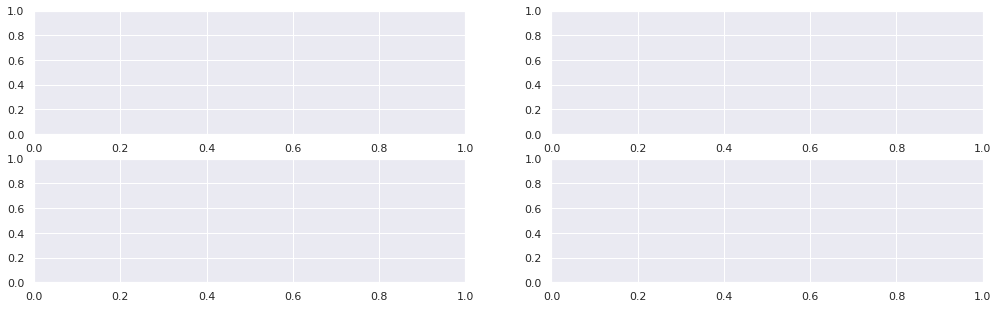

In [27]:

sns.set(font_scale = 1)
plt.gcf().set_size_inches(17, 5)
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(17, 5)


sns.barplot(ax=axes[0],  x = broadfine.index,
                y = genes[0], 
                data = broadfine , palette=broadfine_color_scaled, )
axes[0].set_xticklabels(axes[0].get_xticklabels(), size = 12,rotation = 30, ha='right')
axes[0].set_xlabel("Cell Type", fontsize = 15)
axes[0].set_ylabel("Proportion of Nuclei", fontsize = 15)
axes[0].set_title(geneTitleDict[genes[0]], fontsize = 20)

sns.barplot(ax=axes[1],  x = broadfine.index,
                y = genes[1], 
                data = broadfine , palette=broadfine_color_scaled, )
axes[1].set_xticklabels(axes[1].get_xticklabels(), size = 12,rotation = 30, ha='right')
axes[1].set_xlabel("Cell Type", fontsize = 15)
axes[1].set_ylabel("Proportion of Nuclei", fontsize = 15)
axes[1].set_title(geneTitleDict[genes[1]], fontsize = 20)



sns.barplot(ax=axes[2],  x = broadfine.index,
                y = genes[2], 
                data = broadfine , palette=broadfine_color_scaled, )
axes[2].set_xticklabels(axes[2].get_xticklabels(), size = 12,rotation = 30, ha='right')
axes[2].set_xlabel("Cell Type", fontsize = 15)
axes[2].set_ylabel("Proportion of Nuclei", fontsize = 15)
axes[2].set_title(geneTitleDict[genes[2]], fontsize = 20)


sns.barplot(ax=axes[3],  x = broadfine.index,
                y = genes[3], 
                data = broadfine , palette=broadfine_color_scaled, )
axes[3].set_xticklabels(axes[3].get_xticklabels(), size = 12,rotation = 30, ha='right')
axes[3].set_xlabel("Cell Type", fontsize = 15)
axes[3].set_ylabel("Proportion of Nuclei", fontsize = 15)
axes[3].set_title(geneTitleDict[genes[3]], fontsize = 20)




plt.show()

In [ ]:
broadfine = broadfine.drop('Cell_Type', axis = 1)

<Figure size 1152x576 with 0 Axes>

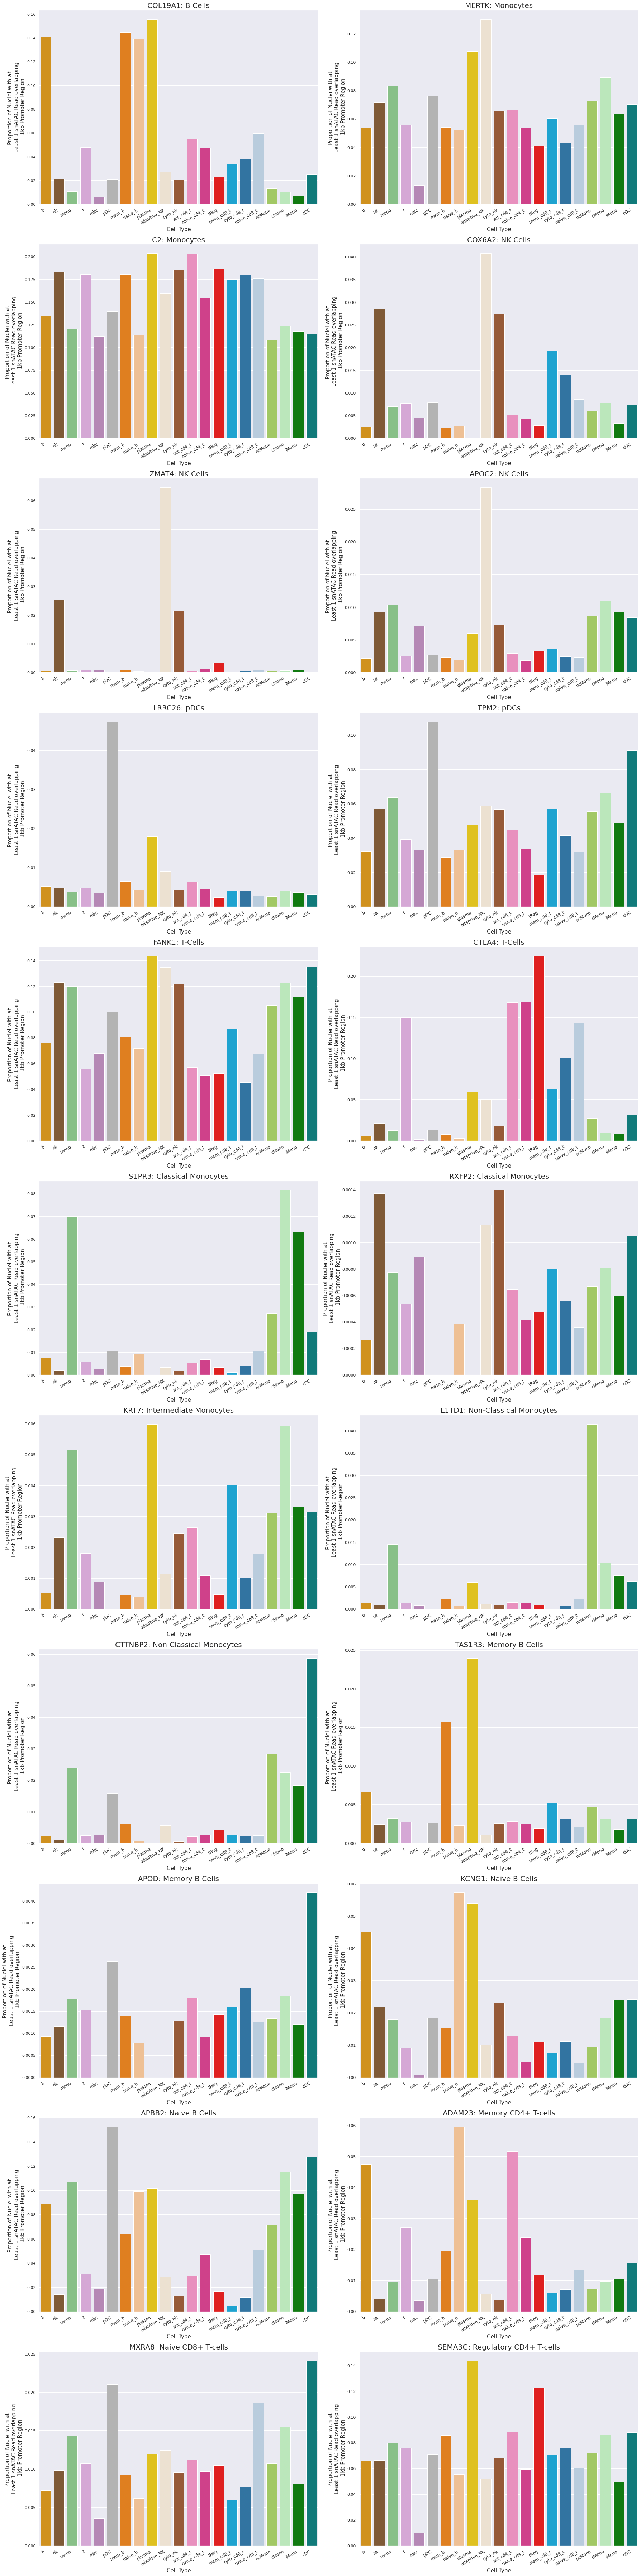

In [30]:
plt.figure(figsize=(16, 8)) 
sns.set(font_scale = 1)
# plt.gcf().set_size_inches(17, 5)
fig, axes = plt.subplots(11,2,figsize=(16, 8))
# ax = ax.flatten()
# fig.set_size_inches(17, 5)
fig.set_figheight(100)
fig.set_figwidth(25)
for gene, ax in zip(list(broadfine.columns), axes.flatten()):
#     print(gene)
    sns.barplot(x = broadfine.index, y = gene, ax=ax,
            data = broadfine, palette=broadfine_color_scaled, )
    ax.set_xticklabels(ax.get_xticklabels(), size = 12,rotation = 30, ha='right')
    ax.set_xlabel("Cell Type", fontsize = 15)
    ax.set_ylabel("Proportion of Nuclei with at \n Least 1 snATAC Read overlapping \n 1kb Promoter Region", fontsize = 15)
    ax.set_title(geneTitleDict[gene], fontsize = 20)
plt.tight_layout()

In [ ]:
len(broadfine.columns)